In [3]:
library(pROC)
library(readxl)
library(gridExtra)
library(ggplot2)

In [4]:
setwd("..")

In [44]:
sampleAnnotFile = "annotation/annotation-78.csv"
sampleRiskFactorFile ="annotation/annotation-obesity-hypertension.xlsx"
pcrValueFile = "data/PCR/PCR-measurement_78.xlsx"
outDir = "Figures-and-Tables/"
table4outfile = "Table-4-AUC-ROC-results.csv"
figure5outfile = "Figure-5-AUC-ROC.svg"
tableS5outfile = "Table-S5-AUC-ROC-results.csv"

In [45]:
# sample annotation
annot = read.csv(file = sampleAnnotFile ,header = T,sep = "\t",stringsAsFactors = F)
annot$gender = ifelse(annot$gender=="f","female","male")
head(annot,3)

,ID,gender,age,group
,<chr>,<chr>,<int>,<chr>
1,SXR0002,female,80,ccRCC
2,SXR0004,male,50,ccRCC
3,SXR0006,male,68,ccRCC


In [46]:
# hypertension + obesity
furtherAnnot = read_excel(sheet = 1, path = sampleRiskFactorFile)
furtherAnnot$hypertension = as.numeric(furtherAnnot$hypertension)
head(furtherAnnot,3)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


ID,obesity,hypertension
<chr>,<dbl>,<dbl>
SXR0002,0,1
SXR0004,1,1
SXR0006,0,1


In [47]:
annot = merge(x=annot, y=furtherAnnot, by="ID", all=T)
head(annot,3)

,ID,gender,age,group,obesity,hypertension
,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>
1,SXR0002,female,80,ccRCC,0,1
2,SXR0004,male,50,ccRCC,1,1
3,SXR0006,male,68,ccRCC,0,1


### read in PCR data
and normalize molec. counts to house keeping gene

In [48]:
pcr = as.data.frame(read_excel(path = pcrValueFile, sheet = 1))
pcr$SNORD99_ACTB_mol = pcr$SNORD99_molec_count/pcr$ACTB_molec_count
pcr = pcr[,c("ID","SNORD99_ACTB_mol")]
head(pcr,2)

,ID,SNORD99_ACTB_mol
,<chr>,<dbl>
1,SXR0002,0.25324223
2,SXR0004,0.09088467


In [49]:
tmp = as.data.frame(read_excel(path = pcrValueFile, sheet = 2))
tmp$SNORD22_RNY3_mol = tmp$SNORD22_molec_count/tmp$RNY3_molec_count
tmp$SNORD26_RNY3_mol = tmp$SNORD26_molec_count/tmp$RNY3_molec_count
tmp = tmp[,c("ID","SNORD22_RNY3_mol","SNORD26_RNY3_mol")]
pcr = merge(pcr,tmp,by="ID")
head(pcr,2)

,ID,SNORD99_ACTB_mol,SNORD22_RNY3_mol,SNORD26_RNY3_mol
,<chr>,<dbl>,<dbl>,<dbl>
1,SXR0002,0.25324223,Inf,NaN
2,SXR0004,0.09088467,0.06216743,0.01914862


In [50]:
tmp = as.data.frame(read_excel(path = pcrValueFile, sheet = 3))
tmp$SNORA50C_ACTB_mol = tmp$SNORA50C_molec_count / tmp$ACTB_molec_count
tmp = tmp[,c("ID","SNORA50C_ACTB_mol")]
pcr = merge(pcr,tmp,by="ID")
head(pcr,3)

,ID,SNORD99_ACTB_mol,SNORD22_RNY3_mol,SNORD26_RNY3_mol,SNORA50C_ACTB_mol
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,SXR0002,0.25324223,Inf,NaN,0.021118913
2,SXR0004,0.09088467,0.06216743,0.01914862,0.004867978
3,SXR0006,0.02808557,0.03330643,0.01758783,0.012005747


In [51]:
pcr = merge(x = pcr,y=annot, by = "ID", all.y=F)
pcr$SNORD99_ACTB_mol[which(is.infinite(pcr$SNORD99_ACTB_mol) | is.nan(pcr$SNORD99_ACTB_mol))] = NA
pcr$SNORD22_RNY3_mol[which(is.infinite(pcr$SNORD22_RNY3_mol) | is.nan(pcr$SNORD22_RNY3_mol))] = NA
pcr$SNORD26_RNY3_mol[which(is.infinite(pcr$SNORD26_RNY3_mol) | is.nan(pcr$SNORD26_RNY3_mol))] = NA
pcr$SNORA50C_ACTB_mol[which(is.infinite(pcr$SNORA50C_ACTB_mol) | is.nan(pcr$SNORA50C_ACTB_mol))] = NA
head(pcr,3)

,ID,SNORD99_ACTB_mol,SNORD22_RNY3_mol,SNORD26_RNY3_mol,SNORA50C_ACTB_mol,gender,age,group,obesity,hypertension
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>
1,SXR0002,0.25324223,NA,NA,0.021118913,female,80,ccRCC,0,1
2,SXR0004,0.09088467,0.06216743,0.01914862,0.004867978,male,50,ccRCC,1,1
3,SXR0006,0.02808557,0.03330643,0.01758783,0.012005747,male,68,ccRCC,0,1


In [52]:
pcr$group_binary = factor(x = pcr$group, levels = c("urolithiasis","ccRCC"))
rownames(pcr) = pcr$ID

# ROC curves and boxplots for Figure 5

In [167]:
glmRocBox = function(dat, var = "SNORA50C_ACTB_mol", label = "SNORA50C / ACTB") {
    
    # log transform and remove NAs:
    dat$var_log = log(dat[,var] + min(setdiff(dat[,var],0), na.rm = T)/2) # pseudo count to avoid log(0)
    formula = as.formula(paste0("group_binary ~ var_log + gender + age"))
    wh = which(!is.na(dat$var_log))
    dat = dat[wh,]
    
    glmModel = glm(data = dat,formula = formula, family = "binomial")
    pVal = summary(glmModel)$coefficients[2,c("Pr(>|z|)")]
    testProb = predict(glmModel, newdata = dat, type = "response") 
    testRoc = roc(group_binary ~ testProb, data = dat , plot = F, print.auc = TRUE, 
                  print.auc.cex=1.2, main = label, cex.main=0.9)

    # best cutoff:
    wh = which.max(testRoc$sensitivities + testRoc$specificities)
    sens = testRoc$sensitivities[wh]
    spec = testRoc$specificities[wh] # max sens and spec combined;
        
    pRoc = ggroc(testRoc)  + 
        annotate(geom = "text",x=0.5,y=0.3, hjust=0,
                  label=paste0("p = ",round(pVal,4),"\nAUC = ",round(testRoc$auc,3),
                               "\nsensitivity = ",round(sens,2),
                               "\nspecificity = ",round(spec,2) ) )
    
    segmData = data.frame(x1 = 1, x2 = 0, y1 = 0, y2 = 1)
    pRoc = pRoc + geom_segment(aes(x = x1, y = y1, xend = x2, yend = y2), color = "grey", linetype=2, data = segmData)
    
    dat$boxplVar = dat[,var]
    pBox = ggplot(data = dat, mapping = aes(x = group, y = boxplVar, fill=group)) + geom_boxplot() + 
        scale_fill_manual(values = c("red", "blue")) + xlab("") + ylab("") + 
                    theme(legend.position="none", axis.text.x = element_text(angle = 30, hjust=1,vjust=1), 
                         plot.margin = unit(c(5.5,5.5,5.5,5.5), "pt")) + 
            scale_y_log10() 
    return(list(pRoc,pBox))
}

In [168]:
plots = list()
plots[[ length(plots)+1]] = glmRocBox(dat = pcr, var = "SNORD99_ACTB_mol", label = "SNORD99")
names(plots)[length(plots)] = "SNORD99"

plots[[ length(plots)+1]] = glmRocBox(dat = pcr, var = "SNORD22_RNY3_mol", label = "SNORD22")
names(plots)[length(plots)] = "SNORD22"

plots[[ length(plots)+1]] = glmRocBox(dat = pcr, var = "SNORD26_RNY3_mol", label = "SNORD26")
names(plots)[length(plots)] = "SNORD26"

plots[[ length(plots)+1]] = glmRocBox(dat = pcr, var = "SNORA50C_ACTB_mol", label = "SNORA50C")
names(plots)[length(plots)] = "SNORA50C"


Setting levels: control = urolithiasis, case = ccRCC

Setting direction: controls < cases

Setting levels: control = urolithiasis, case = ccRCC

Setting direction: controls < cases

Setting levels: control = urolithiasis, case = ccRCC

Setting direction: controls < cases

Setting levels: control = urolithiasis, case = ccRCC

Setting direction: controls < cases



Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 3 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 7 rows containing non-finite values (`stat_boxplot()`).”


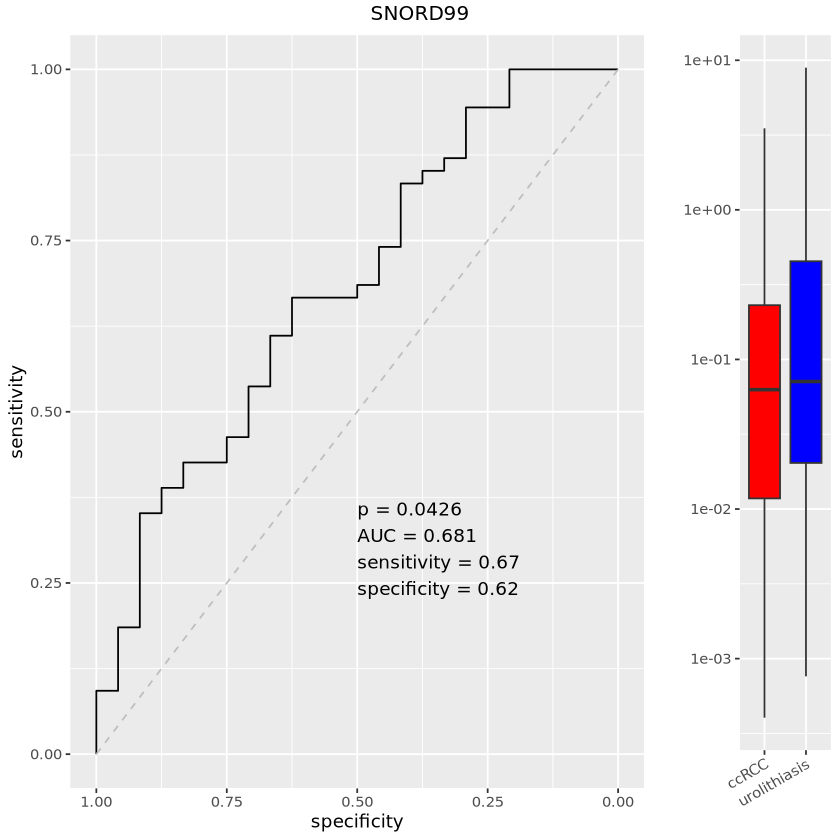

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 10 rows containing non-finite values (`stat_boxplot()`).”


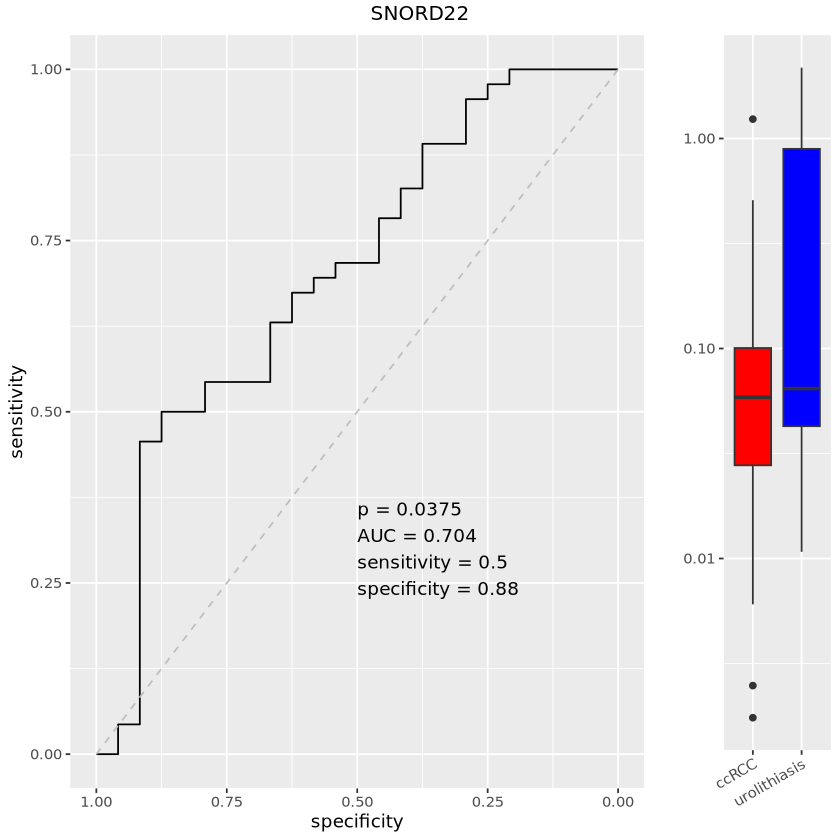

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 4 rows containing non-finite values (`stat_boxplot()`).”


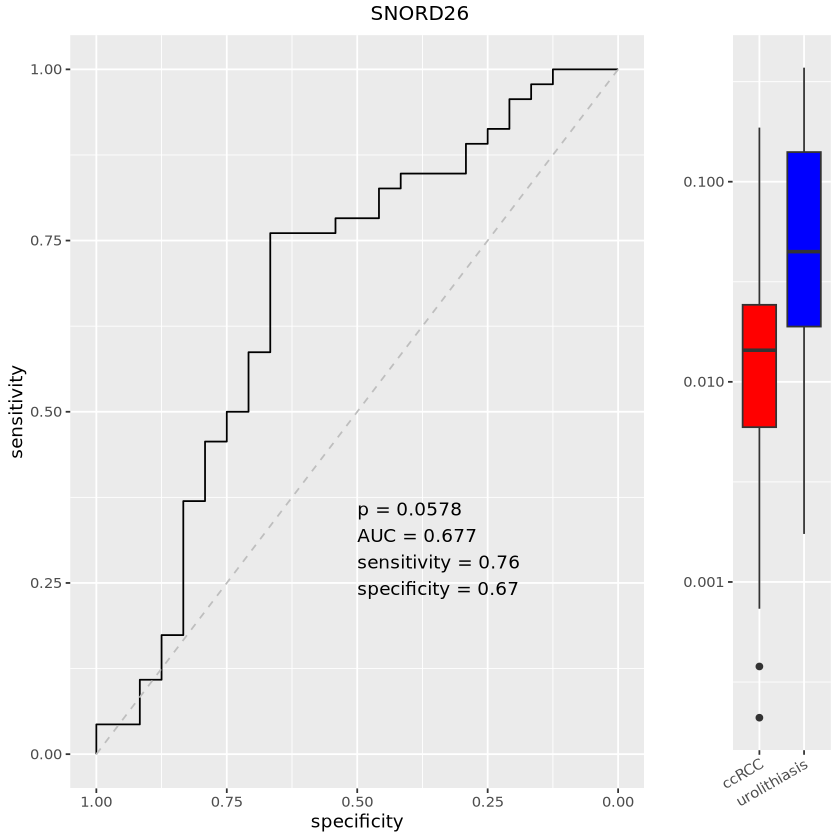

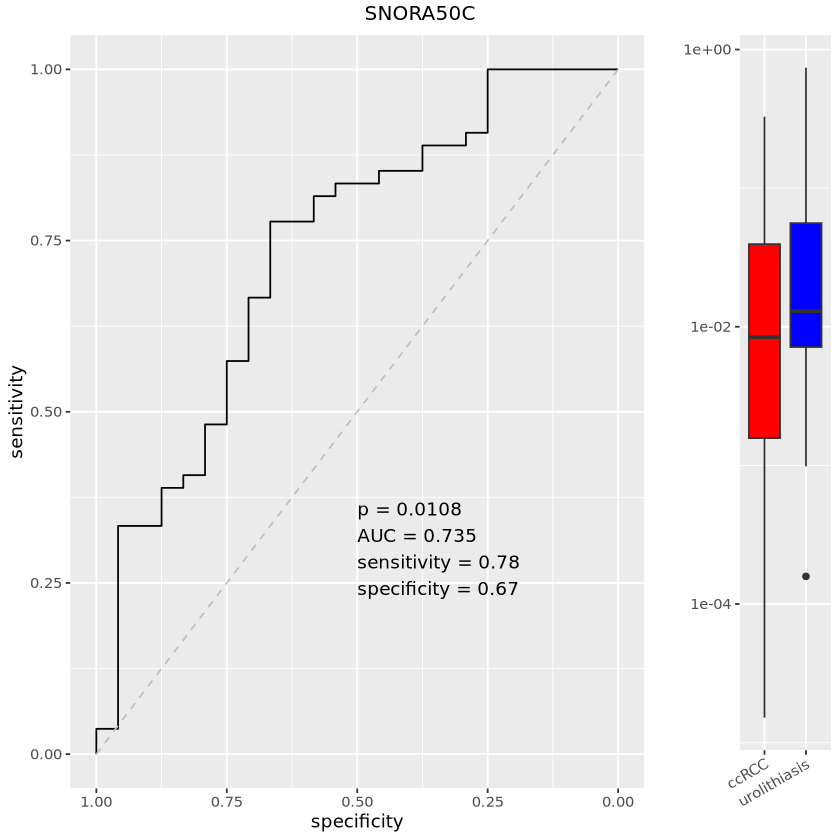

In [169]:
for(i in 1:length(plots)) {
    grid.arrange(plots[[i]][[1]], plots[[i]][[2]], ncol=2, widths=c(3.5,1),top=names(plots)[i])
}

In [15]:
svg(filename = paste0(outDir,figure5outfile), width=12,height=12)
grid.arrange(plots[[1]][[1]], plots[[1]][[2]], plots[[2]][[1]], plots[[2]][[2]], 
             plots[[3]][[1]], plots[[3]][[2]], plots[[4]][[1]], plots[[4]][[2]], 
             ncol=4, widths=c(3.5,1,3.5,1))
dev.off()

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 3 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 7 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 10 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 4 rows containing non-finite values (`stat_boxplot()`).”


png 
  2

## Model statistics for Table 4 and S5
optional adjustment for hypertension and obesity

In [175]:
glmAccPval = function(dat, variables = c("SNORD99" = "SNORD99_ACTB_mol","SNORD22" = "SNORD22_RNY3_mol"),
                             confounders = c("age","gender")) {
    varValues = sapply(variables, function(var) 
        log(dat[,var] + min(setdiff(dat[,var],0), na.rm = T)/2))
    colnames(varValues) = paste0("var_",1:length(variables))
    dat = cbind(dat, varValues)

    formula = as.formula(paste0("group_binary ~ ",paste0(colnames(varValues),collapse=" + ")," + ",
           paste0(confounders,collapse=" + ")))
    # remove rows where any variable is NA
    wh = which(!apply(dat[,c(colnames(varValues),confounders), drop=F],1, function(l) any(is.na(l))))
    dat = dat[wh,]

    glmModel = glm(data = dat,formula = formula, family = "binomial")   
    # p-value of whole mode, i.e. better than a null model?
    # from https://stats.stackexchange.com/questions/129958/glm-in-r-which-pvalue-represents-the-goodness-of-fit-of-entire-model
    nullModel = glm(formula = "group_binary ~ 1",data = dat, family = "binomial")   
    p_model = with(anova(nullModel,glmModel),pchisq(Deviance,Df,lower.tail=FALSE)[2]) 

    coef = summary(glmModel)$coefficients
    pValue = coef[2,c("Pr(>|z|)")] # p-val of the first variable only

    testProb = predict(glmModel, newdata = dat, type = "response") 
    label = paste0(paste0(names(variables),collapse=" + ")," + ",paste0(confounders,collapse=" + "))
    testRoc = roc(group_binary ~ testProb, data = dat , plot = F, print.auc = TRUE, 
                      print.auc.cex=1.2, main = label, cex.main=0.9, quiet=T)
       
    # best cutoff:
    wh = which.max(testRoc$sensitivities + testRoc$specificities)
    cutoff = testRoc$thresholds[wh]
    confusion = table(ifelse(testProb>cutoff, 1, 0), ifelse(dat$group_binary=="ccRCC",1,0))
    confusion = confusion[c("1","0"),c("1","0")]

    # accuracy: 
    #  from https://stackoverflow.com/questions/58145806/r-studio-i-need-the-confidence-intervals-of-sensitivity-and-specificity-and-po
    #  and https://m-clark.github.io/confusionMatrix/reference/calc_stats.html
                      
    D = confusion[2,2]; C = confusion[2,1]; B = confusion[1,2]; A = confusion[1,1]
    accuracy = (A+D)/(A+B+C+D)
    sens = A / (A + C)
    spec = D / (D + B)

    # odds ratio over the interquartile range of the first variable (gene) only
    var = colnames(varValues)[1]
    IQR = unname(diff(quantile(dat[,var],c(0.25,0.75))))
    OR_iqr = exp(glmModel$coefficients[2] * IQR)
                                          
    stats = data.frame(row.names = NULL, formula = label, Sensitivity = sens, Specificity=spec, 
                       Accuracy=accuracy, AUC=testRoc$auc, OR_iqr, p_model = p_model, p_value_1 = pValue,
                       stringsAsFactors = F)
    
    return( stats)
}

In [171]:
allGeneVars = c("SNORD99_ACTB_mol","SNORD22_RNY3_mol","SNORD26_RNY3_mol","SNORA50C_ACTB_mol")
names(allGeneVars) = c("SNORD99","SNORD22","SNORD26","SNORA50C")

## 1 gene for Table 4

### age + gender

In [196]:
allRes = NULL
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD99")],
                  confounders = c("age","gender")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD22")],
                  confounders = c("age","gender")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD26")],
                  confounders = c("age","gender")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORA50C")],
                  confounders = c("age","gender")))

### age + gender + adipositas + hypertension

In [197]:
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD99")],
                  confounders = c("age","gender","obesity","hypertension")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD22")],
                  confounders = c("age","gender","obesity","hypertension")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD26")],
                  confounders = c("age","gender","obesity","hypertension")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORA50C")],
                  confounders = c("age","gender","obesity","hypertension")))

In [198]:
# take the gene p-value for models not adjusted for obesity/hypertension
# take the model p-value for the other models:
allRes$p = allRes$p_value_1
allRes$p[5:8]  = allRes$p_value_1[5:8]

In [199]:
allRes
allRes$p_model=NULL; allRes$p_value_1=NULL
allRes

formula,Sensitivity,Specificity,Accuracy,AUC,OR_iqr,p_model,p_value_1,p
<chr>,<dbl>,<dbl>,<dbl>,<auc>,<dbl>,<dbl>,<dbl>,<dbl>
SNORD99 + age + gender,0.6666667,0.6250000,0.6538462,0.6813272,0.3835543,0.032209009,0.042645447,0.042645447
SNORD22 + age + gender,0.5000000,0.8750000,0.6285714,0.7038043,0.5596344,0.050634857,0.037504033,0.037504033
SNORD26 + age + gender,0.7608696,0.6666667,0.7285714,0.6766304,0.5726766,0.080533743,0.057769431,0.057769431
SNORA50C + age + gender,0.7777778,0.6666667,0.7435897,0.7353395,0.2104662,0.004099770,0.010762276,0.010762276
SNORD99 + age + gender + obesity + hypertension,0.9000000,0.4166667,0.7432432,0.6933333,0.3995781,0.065703847,0.062234084,0.062234084
SNORD22 + age + gender + obesity + hypertension,0.7906977,0.6666667,0.7462687,0.7325581,0.5767236,0.058550089,0.052359396,0.052359396
SNORD26 + age + gender + obesity + hypertension,0.6279070,0.7500000,0.6716418,0.7199612,0.4931236,0.049502701,0.040329371,0.040329371
SNORA50C + age + gender + obesity + hypertension,0.8400000,0.6250000,0.7702703,0.7658333,0.1777395,0.004580473,0.008346226,0.008346226


formula,Sensitivity,Specificity,Accuracy,AUC,OR_iqr,p
<chr>,<dbl>,<dbl>,<dbl>,<auc>,<dbl>,<dbl>
SNORD99 + age + gender,0.6666667,0.6250000,0.6538462,0.6813272,0.3835543,0.042645447
SNORD22 + age + gender,0.5000000,0.8750000,0.6285714,0.7038043,0.5596344,0.037504033
SNORD26 + age + gender,0.7608696,0.6666667,0.7285714,0.6766304,0.5726766,0.057769431
SNORA50C + age + gender,0.7777778,0.6666667,0.7435897,0.7353395,0.2104662,0.010762276
SNORD99 + age + gender + obesity + hypertension,0.9000000,0.4166667,0.7432432,0.6933333,0.3995781,0.062234084
SNORD22 + age + gender + obesity + hypertension,0.7906977,0.6666667,0.7462687,0.7325581,0.5767236,0.052359396
SNORD26 + age + gender + obesity + hypertension,0.6279070,0.7500000,0.6716418,0.7199612,0.4931236,0.040329371
SNORA50C + age + gender + obesity + hypertension,0.8400000,0.6250000,0.7702703,0.7658333,0.1777395,0.008346226


In [200]:
outf = paste0(outDir,table4outfile)
write.table(x = allRes, file = outf,quote = F, sep = "\t",row.names = F)

## Suppl. Table S5, 2, 3, 4 genes - with/without obesity and hypertension

### 2 genes, age + gender:

In [205]:
allRes = NULL
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD99","SNORD22")],
                  confounders = c("age","gender")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD99","SNORD26")],
                  confounders = c("age","gender")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD99","SNORA50C")],
                  confounders = c("age","gender")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD22","SNORD26")],
                  confounders = c("age","gender")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD22","SNORA50C")],
                  confounders = c("age","gender")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD26","SNORA50C")],
                  confounders = c("age","gender")))

### 2 genes, age, gender, obesity, hypertension:

In [206]:
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD99","SNORD22")],
                  confounders = c("age","gender","obesity","hypertension")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD99","SNORD26")],
                  confounders = c("age","gender","obesity","hypertension")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD99","SNORA50C")],
                  confounders = c("age","gender","obesity","hypertension")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD22","SNORD26")],
                  confounders = c("age","gender","obesity","hypertension")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD22","SNORA50C")],
                  confounders = c("age","gender","obesity","hypertension")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD26","SNORA50C")],
                  confounders = c("age","gender","obesity","hypertension")))

### 3 genes, gender + age

In [207]:
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD99", "SNORD22", "SNORD26")],
                  confounders = c("age","gender")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD99", "SNORD22", "SNORA50C")],
                  confounders = c("age","gender")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD99", "SNORD26", "SNORA50C")],
                  confounders = c("age","gender")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD22", "SNORD26", "SNORA50C")],
                  confounders = c("age","gender")))

### 3 genes, gender + age + obesity + hypertension

In [208]:
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD99", "SNORD22", "SNORD26")],
                  confounders = c("age","gender","obesity","hypertension")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD99", "SNORD22", "SNORA50C")],
                  confounders = c("age","gender","obesity","hypertension")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD99", "SNORD26", "SNORA50C")],
                  confounders = c("age","gender","obesity","hypertension")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD22", "SNORD26", "SNORA50C")],
                  confounders = c("age","gender","obesity","hypertension")))

### 4 genes, gender + age (obesity + hypertension)

In [210]:
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD99", "SNORD22", "SNORD26", "SNORA50C")],
                  confounders = c("age","gender")))
allRes = rbind(allRes,glmAccPval(dat = pcr,variables = allGeneVars[c("SNORD99", "SNORD22", "SNORD26", "SNORA50C")],
                  confounders = c("age","gender","obesity","hypertension")))

In [211]:
allRes

formula,Sensitivity,Specificity,Accuracy,AUC,OR_iqr,p_model,p_value_1
<chr>,<dbl>,<dbl>,<dbl>,<auc>,<dbl>,<dbl>,<dbl>
SNORD99 + SNORD22 + age + gender,0.5869565,0.8750000,0.6857143,0.7137681,0.5501707,0.059494957,0.2695481
SNORD99 + SNORD26 + age + gender,0.8478261,0.5416667,0.7428571,0.6938406,0.5085078,0.071282724,0.1890850
SNORD99 + SNORA50C + age + gender,0.7777778,0.6666667,0.7435897,0.7353395,0.9928350,0.010056295,0.9910981
SNORD22 + SNORD26 + age + gender,0.6086957,0.7916667,0.6714286,0.6992754,0.6486234,0.059077899,0.1482435
SNORD22 + SNORA50C + age + gender,0.8043478,0.6666667,0.7571429,0.7336957,0.7301066,0.016835532,0.2874600
SNORD26 + SNORA50C + age + gender,0.7826087,0.5833333,0.7142857,0.7291667,0.7971941,0.022713890,0.4816869
SNORD99 + SNORD22 + age + gender + obesity + hypertension,0.8372093,0.6250000,0.7611940,0.7335271,0.5207664,0.062932010,0.2682993
SNORD99 + SNORD26 + age + gender + obesity + hypertension,0.9767442,0.4166667,0.7761194,0.7286822,0.5508978,0.057209988,0.3047482
SNORD99 + SNORA50C + age + gender + obesity + hypertension,0.9000000,0.6250000,0.8108108,0.7725000,1.2285953,0.009072965,0.7510651


In [212]:
allRes$OR_iqr = NULL; allRes$p_value_1=NULL

In [193]:
allRes

formula,Sensitivity,Specificity,Accuracy,AUC,p_model
<chr>,<dbl>,<dbl>,<dbl>,<auc>,<dbl>
SNORD99 + SNORD22 + age + gender,0.5869565,0.8750000,0.6857143,0.7137681,0.059494957
SNORD99 + SNORD26 + age + gender,0.8478261,0.5416667,0.7428571,0.6938406,0.071282724
SNORD99 + SNORA50C + age + gender,0.7777778,0.6666667,0.7435897,0.7353395,0.010056295
SNORD22 + SNORD26 + age + gender,0.6086957,0.7916667,0.6714286,0.6992754,0.059077899
SNORD22 + SNORA50C + age + gender,0.8043478,0.6666667,0.7571429,0.7336957,0.016835532
SNORD26 + SNORA50C + age + gender,0.7826087,0.5833333,0.7142857,0.7291667,0.022713890
SNORD99 + SNORD22 + age + gender + obesity + hypertension,0.8372093,0.6250000,0.7611940,0.7335271,0.062932010
SNORD99 + SNORD26 + age + gender + obesity + hypertension,0.9767442,0.4166667,0.7761194,0.7286822,0.057209988
SNORD99 + SNORA50C + age + gender + obesity + hypertension,0.9000000,0.6250000,0.8108108,0.7725000,0.009072965


In [213]:
outf = paste0(outDir,tableS5outfile)
write.table(x = allRes, file = outf,quote = F, sep = "\t",row.names = F)